TPRA Risk Assessment Dashboard
Loading vendor risk assessment data...
✓ Loaded 35 vendor risk assessments
✓ Loaded 35 vendor records

Generating Risk Assessment Dashboard...
----------------------------------------
Dashboard Overview:
• Vendors analyzed: 35
• Average risk score: 92.2%

Creating visualizations...
1. Risk Level Distribution


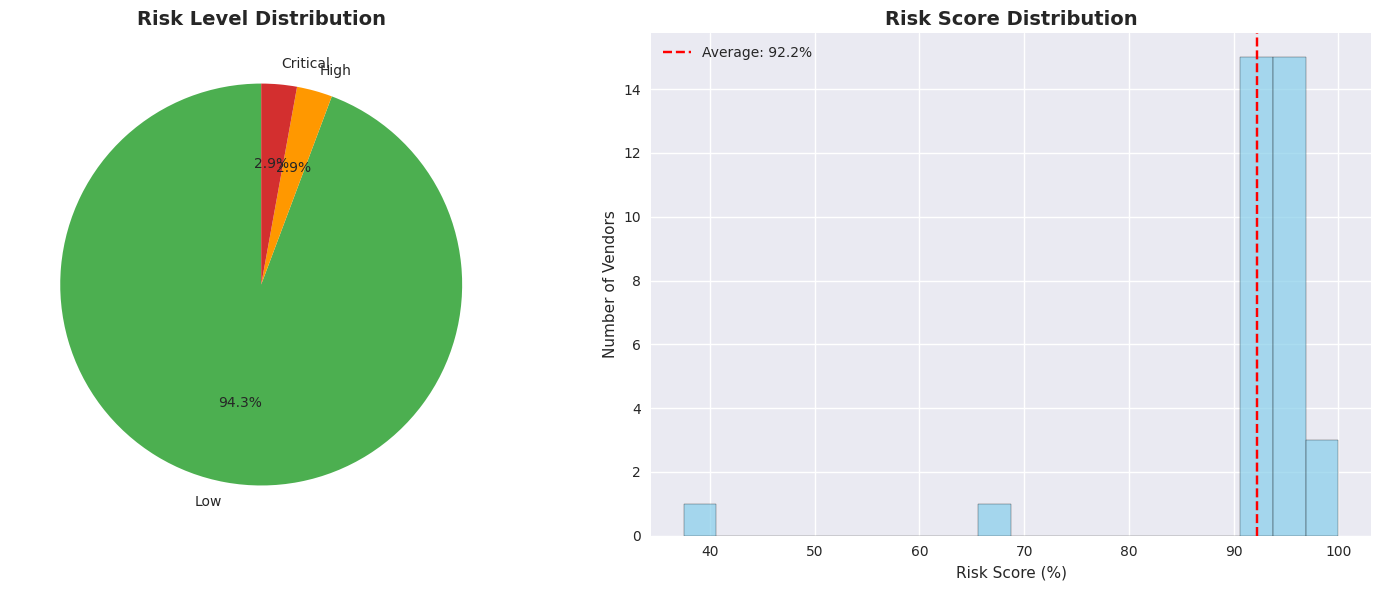

2. Category Risk Breakdown


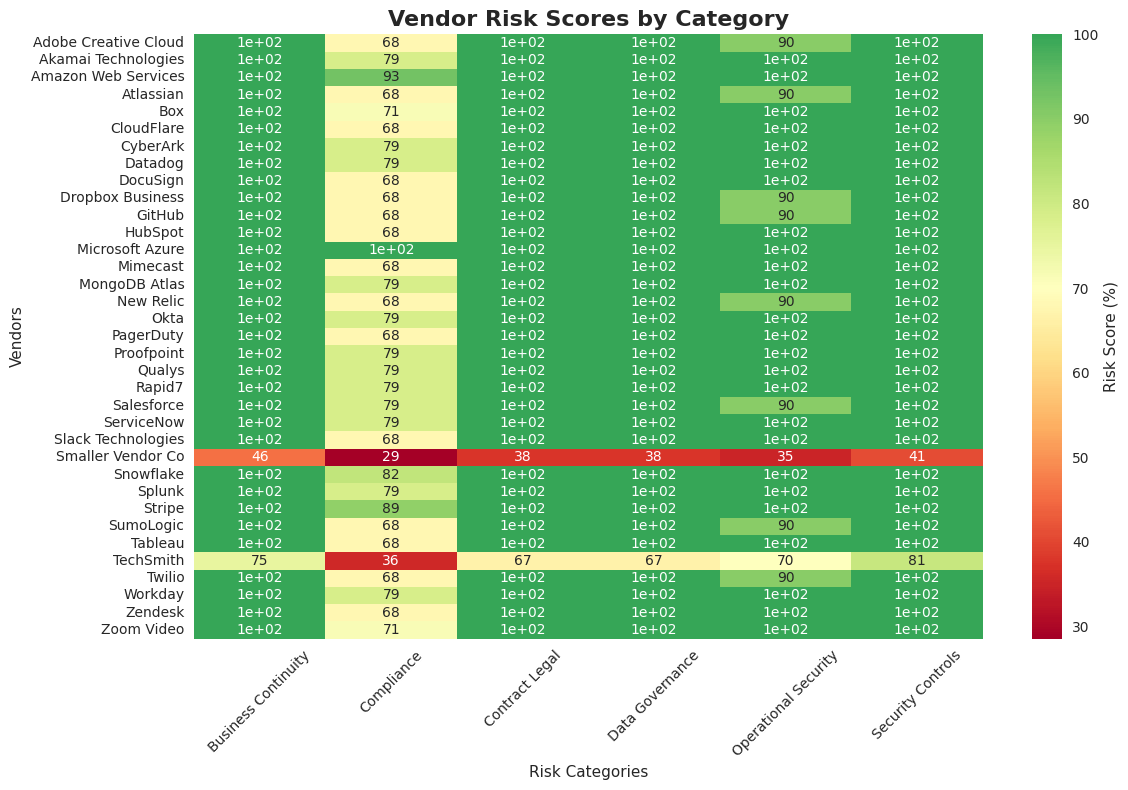

3. Contract Value vs Risk Analysis


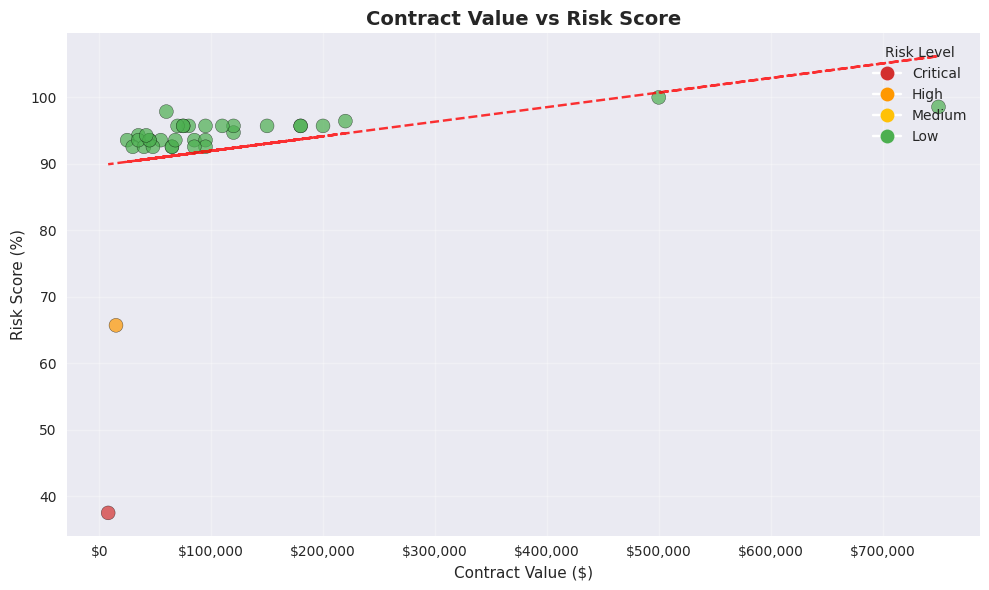

4. Industry Risk Comparison


KeyError: "Column(s) ['contract_value'] do not exist"

In [2]:
# Third-Party Risk Assessment (TPRA) Dashboard
# Interactive visualization and analysis of vendor risk assessments

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("TPRA Risk Assessment Dashboard")
print("="*50)
print("Loading vendor risk assessment data...")

# Load the data
try:
    # Load vendor data
    vendors_df = pd.read_csv('../data/vendors_sample.csv')
    
    # Load risk assessment results if available
    try:
        with open('../data/risk_scores.json', 'r') as f:
            risk_results = json.load(f)
        risk_df = pd.DataFrame(risk_results)
        print(f"✓ Loaded {len(risk_df)} vendor risk assessments")
    except FileNotFoundError:
        print("⚠ Risk scores not found. Run risk_assessment.py first.")
        risk_df = pd.DataFrame()
    
    print(f"✓ Loaded {len(vendors_df)} vendor records")
    
except FileNotFoundError:
    print("❌ Vendor data file not found. Creating sample data...")
    # Create sample data for demonstration
    vendors_df = pd.DataFrame({
        'vendor_name': ['Microsoft Azure', 'AWS', 'Salesforce', 'Slack', 'Small Vendor'],
        'vendor_type': ['Cloud', 'Cloud', 'CRM', 'Communication', 'Software'],
        'contract_value': [500000, 750000, 120000, 45000, 8000],
        'industry': ['Technology', 'Technology', 'Technology', 'Technology', 'Technology']
    })

# Data Analysis Functions

def calculate_risk_metrics(df):
    """Calculate key risk metrics from vendor data"""
    if df.empty:
        return {}
    
    metrics = {
        'total_vendors': len(df),
        'total_contract_value': df['contract_value'].sum() if 'contract_value' in df.columns else 0,
        'avg_contract_value': df['contract_value'].mean() if 'contract_value' in df.columns else 0,
        'risk_distribution': df['risk_level'].value_counts().to_dict() if 'risk_level' in df.columns else {},
        'avg_risk_score': df['overall_score'].mean() if 'overall_score' in df.columns else 0
    }
    return metrics

def create_risk_distribution_chart(df):
    """Create risk level distribution visualization"""
    if df.empty or 'risk_level' not in df.columns:
        print("No risk level data available for visualization")
        return None
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Risk level counts
    risk_counts = df['risk_level'].value_counts()
    colors = {'Critical': '#d32f2f', 'High': '#ff9800', 'Medium': '#ffc107', 'Low': '#4caf50'}
    risk_colors = [colors.get(level, '#gray') for level in risk_counts.index]
    
    ax1.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
            colors=risk_colors, startangle=90)
    ax1.set_title('Risk Level Distribution', fontsize=14, fontweight='bold')
    
    # Risk scores histogram
    ax2.hist(df['overall_score'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Risk Score (%)')
    ax2.set_ylabel('Number of Vendors')
    ax2.set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
    ax2.axvline(df['overall_score'].mean(), color='red', linestyle='--', 
                label=f'Average: {df["overall_score"].mean():.1f}%')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_category_breakdown_chart(df):
    """Create category-wise risk breakdown"""
    if df.empty or 'category_scores' not in df.columns:
        print("No category score data available")
        return None
    
    # Extract category scores
    categories = ['security_controls', 'compliance', 'data_governance', 
                 'business_continuity', 'operational_security', 'contract_legal']
    
    category_data = []
    for idx, row in df.iterrows():
        if isinstance(row['category_scores'], dict):
            for cat, score in row['category_scores'].items():
                category_data.append({
                    'vendor': row['vendor_name'],
                    'category': cat.replace('_', ' ').title(),
                    'score': score
                })
    
    if not category_data:
        print("No valid category data found")
        return None
    
    cat_df = pd.DataFrame(category_data)
    
    # Create heatmap
    pivot_data = cat_df.pivot(index='vendor', columns='category', values='score')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_data, annot=True, cmap='RdYlGn', center=70, 
                cbar_kws={'label': 'Risk Score (%)'})
    plt.title('Vendor Risk Scores by Category', fontsize=16, fontweight='bold')
    plt.xlabel('Risk Categories')
    plt.ylabel('Vendors')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def create_contract_value_risk_scatter(df):
    """Create scatter plot of contract value vs risk score"""
    if df.empty or 'contract_value' not in df.columns or 'overall_score' not in df.columns:
        print("Insufficient data for contract value analysis")
        return None
    
    plt.figure(figsize=(10, 6))
    
    # Color points by risk level
    risk_colors = {'Critical': '#d32f2f', 'High': '#ff9800', 'Medium': '#ffc107', 'Low': '#4caf50'}
    colors = [risk_colors.get(level, 'gray') for level in df['risk_level']]
    
    scatter = plt.scatter(df['contract_value'], df['overall_score'], 
                         c=colors, s=100, alpha=0.7, edgecolors='black')
    
    # Add trend line
    z = np.polyfit(df['contract_value'], df['overall_score'], 1)
    p = np.poly1d(z)
    plt.plot(df['contract_value'], p(df['contract_value']), "r--", alpha=0.8)
    
    plt.xlabel('Contract Value ($)')
    plt.ylabel('Risk Score (%)')
    plt.title('Contract Value vs Risk Score', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Format x-axis to show currency
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=10, label=level)
                      for level, color in risk_colors.items()]
    plt.legend(handles=legend_elements, title='Risk Level', loc='upper right')
    
    plt.tight_layout()
    plt.show()

def create_industry_comparison(df):
    """Create industry risk comparison chart"""
    if df.empty or 'industry' not in df.columns:
        print("No industry data available")
        return None
    
    # Calculate average risk score by industry
    industry_stats = df.groupby('industry').agg({
        'overall_score': ['mean', 'count', 'std'],
        'contract_value': 'sum'
    }).round(2)
    
    industry_stats.columns = ['Avg Risk Score', 'Vendor Count', 'Risk Std Dev', 'Total Contract Value']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Average risk score by industry
    industry_stats['Avg Risk Score'].plot(kind='bar', ax=ax1, color='lightcoral')
    ax1.set_title('Average Risk Score by Industry', fontweight='bold')
    ax1.set_ylabel('Average Risk Score (%)')
    ax1.set_xlabel('Industry')
    ax1.tick_params(axis='x', rotation=45)
    
    # Total contract value by industry
    industry_stats['Total Contract Value'].plot(kind='bar', ax=ax2, color='lightblue')
    ax2.set_title('Total Contract Value by Industry', fontweight='bold')
    ax2.set_ylabel('Total Contract Value ($)')
    ax2.set_xlabel('Industry')
    ax2.tick_params(axis='x', rotation=45)
    
    # Format y-axis for currency
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    plt.show()
    
    # Display the statistics table
    print("\nIndustry Risk Statistics:")
    print("="*50)
    print(industry_stats)

def create_risk_trend_analysis(df):
    """Create risk trend analysis over time"""
    if df.empty or 'assessment_date' not in df.columns:
        print("No temporal data available for trend analysis")
        return None
    
    # Convert assessment_date to datetime
    df['assessment_date'] = pd.to_datetime(df['assessment_date'])
    
    # Create monthly risk averages
    monthly_trends = df.set_index('assessment_date').resample('M')['overall_score'].agg(['mean', 'count'])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Risk score trend
    ax1.plot(monthly_trends.index, monthly_trends['mean'], marker='o', linewidth=2, color='blue')
    ax1.set_title('Average Risk Score Trend', fontweight='bold')
    ax1.set_ylabel('Average Risk Score (%)')
    ax1.grid(True, alpha=0.3)
    
    # Assessment volume trend
    ax2.bar(monthly_trends.index, monthly_trends['count'], alpha=0.7, color='green')
    ax2.set_title('Assessment Volume Trend', fontweight='bold')
    ax2.set_ylabel('Number of Assessments')
    ax2.set_xlabel('Month')
    
    plt.tight_layout()
    plt.show()

def generate_executive_summary(df):
    """Generate executive summary of risk assessment"""
    if df.empty:
        print("No data available for executive summary")
        return None
    
    metrics = calculate_risk_metrics(df)
    
    print("\n" + "="*60)
    print("EXECUTIVE SUMMARY - THIRD-PARTY RISK ASSESSMENT")
    print("="*60)
    print(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
    print()
    
    # Key metrics
    print("KEY METRICS:")
    print(f"• Total Vendors Assessed: {metrics['total_vendors']:,}")
    if metrics['total_contract_value'] > 0:
        print(f"• Total Contract Value: ${metrics['total_contract_value']:,.2f}")
        print(f"• Average Contract Value: ${metrics['avg_contract_value']:,.2f}")
    if metrics['avg_risk_score'] > 0:
        print(f"• Average Risk Score: {metrics['avg_risk_score']:.1f}%")
    print()
    
    # Risk distribution
    if metrics['risk_distribution']:
        print("RISK DISTRIBUTION:")
        for level, count in metrics['risk_distribution'].items():
            percentage = (count / metrics['total_vendors']) * 100
            print(f"• {level} Risk: {count} vendors ({percentage:.1f}%)")
        print()
    
    # High-risk vendors
    if 'risk_level' in df.columns:
        high_risk = df[df['risk_level'].isin(['Critical', 'High'])]
        if not high_risk.empty:
            print("HIGH-RISK VENDORS REQUIRING ATTENTION:")
            for _, vendor in high_risk.iterrows():
                score = vendor.get('overall_score', 'N/A')
                print(f"• {vendor['vendor_name']}: {score}% ({vendor['risk_level']} Risk)")
            print()
    
    # Recommendations
    print("KEY RECOMMENDATIONS:")
    critical_count = metrics['risk_distribution'].get('Critical', 0)
    high_count = metrics['risk_distribution'].get('High', 0)
    
    if critical_count > 0:
        print(f"• IMMEDIATE ACTION: {critical_count} vendor(s) pose critical risk")
    if high_count > 0:
        print(f"• Develop mitigation plans for {high_count} high-risk vendor(s)")
    if metrics['avg_risk_score'] < 70:
        print("• Overall vendor risk posture below acceptable threshold")
    else:
        print("• Maintain current risk management practices")
    
    print("• Conduct quarterly risk reviews for all vendors")
    print("• Implement continuous monitoring for critical vendors")
    print()
    print("="*60)

# Main Analysis Execution
print("\nGenerating Risk Assessment Dashboard...")
print("-" * 40)

# Calculate and display metrics
if not risk_df.empty:
    metrics = calculate_risk_metrics(risk_df)
    
    print(f"Dashboard Overview:")
    print(f"• Vendors analyzed: {metrics['total_vendors']}")
    if metrics['avg_risk_score'] > 0:
        print(f"• Average risk score: {metrics['avg_risk_score']:.1f}%")
    print()
    
    # Generate all visualizations
    print("Creating visualizations...")
    
    # 1. Risk Distribution
    print("1. Risk Level Distribution")
    create_risk_distribution_chart(risk_df)
    
    # 2. Category Breakdown
    print("2. Category Risk Breakdown")
    create_category_breakdown_chart(risk_df)
    
    # 3. Contract Value Analysis
    if 'contract_value' in vendors_df.columns:
        print("3. Contract Value vs Risk Analysis")
        # Merge with vendor data for contract values
        merged_df = risk_df.merge(vendors_df[['vendor_name', 'contract_value']], 
                                 on='vendor_name', how='left')
        create_contract_value_risk_scatter(merged_df)
    
    # 4. Industry Comparison
    if 'industry' in vendors_df.columns:
        print("4. Industry Risk Comparison")
        merged_df = risk_df.merge(vendors_df[['vendor_name', 'industry']], 
                                 on='vendor_name', how='left')
        create_industry_comparison(merged_df)
    
    # 5. Trend Analysis
    print("5. Risk Trend Analysis")
    create_risk_trend_analysis(risk_df)
    
    # 6. Executive Summary
    generate_executive_summary(risk_df)
    
else:
    print("⚠ No risk assessment data available.")
    print("Please run the risk_assessment.py script first to generate risk scores.")
    print()
    print("Sample vendor data overview:")
    print(vendors_df.head())

print("\nDashboard generation complete!")
print("To update the dashboard, re-run the risk assessment and then this notebook.")